<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (18,18,3)
latent_dim = 2
batch_size = 256

v_split = 0.05

In [3]:
! git clone https://github.com/AtSourav/CatsnDogs_img_dataset.git           # ! let's us use shell commands

fatal: destination path 'CatsnDogs_img_dataset' already exists and is not an empty directory.


In [5]:
img_dir = 'CatsnDogs_img_dataset/Dataset_aug/'
dir_size = len([imgs for imgs in os.listdir(img_dir)])

# we'll try to create one training dataset as one batch, and similarly for the validation dataset. These are dataset objects. Then we'll need to convert each of of these into numpy.ndarray to mimic how the model.fit() works on mnist data.
# We'll split the data into smaller batches while training with the fit() function.

data_train = utils.image_dataset_from_directory(img_dir, labels=None, validation_split=v_split, subset="training", seed=111, image_size=(160,160), color_mode='rgb', shuffle=True, batch_size=int(0.9*dir_size))

data_valid = utils.image_dataset_from_directory(img_dir, labels=None, validation_split=v_split, subset="validation", seed=111, image_size=(160,160), color_mode='rgb', shuffle=True, batch_size=int(0.1*dir_size))

print(type(data_train))

for image_batch in data_train:
  print(image_batch.shape)
  break

for image_batch in data_valid:
  print(image_batch.shape)
  break

batch = next(iter(data_train))

print(batch.shape)
print(type(batch))

Found 5110 files belonging to 1 classes.
Using 4855 files for training.
Found 5110 files belonging to 1 classes.
Using 255 files for validation.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(4599, 160, 160, 3)
(255, 160, 160, 3)
(4599, 160, 160, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [6]:
train_set = next(iter(data_train))
print(train_set.shape)

valid_set = next(iter(data_valid))
print(valid_set.shape)

r_train_set = layers.Resizing(18, 18, interpolation="bilinear")(train_set)
print(r_train_set.shape)

r_valid_set = layers.Resizing(18, 18, interpolation="bilinear")(valid_set)
print(r_valid_set.shape)

(4599, 160, 160, 3)
(255, 160, 160, 3)
(4599, 18, 18, 3)
(255, 18, 18, 3)


In [7]:
encoder_input = keras.Input(shape=input_size)

#x = layers.Resizing(18, 18, interpolation="bilinear")(encoder_input)

x = layers.Rescaling(1./255)(encoder_input)      # to ensure pixel values between [0,1], it's better for neural networks to work on small numbers

x = layers.Conv2D(16, 3, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)    # with strides=None this defaults to pool_size
x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(32, 3, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 3, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(128, 3, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
#x = layers.BatchNormalization(axis=-1)(x)
#x = layers.ReLU()(x)

x = layers.Flatten()(x)       # dimension of vector produced 8*8*256

# we won't add any extra dense layers for now

x = layers.Dense(4*latent_dim)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18, 18, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 18, 18, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   448         ['rescaling[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 16)     0           ['conv2d[0][0]']                 
                                                                                            

The number of trainable parameters might just be too big for the dataset, possibility of overtraining, we'll see how it goes. Let's make the decoder now.

In [8]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(4*latent_dim)(latent_input)

x = layers.Dense(1*64)(x)
x = layers.ReLU()(x)
x = layers.Reshape((1,1,64))(x)

#x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.ReLU()(x)
                                                        # axis=-1 is set by default
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 3, strides=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 3, activation='sigmoid', strides=3, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 24        
                                                                 
 dense_2 (Dense)             (None, 64)                576       
                                                                 
 re_lu_3 (ReLU)              (None, 64)                0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 32)         18464     
 nspose)                                                         
                                                           

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [9]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 18, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               24588     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 18, 18, 3)         24315     
                                                                 
Total params: 48,903
Trainable params: 48,583
Non-trainable params: 320
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior. Since we have continuous values for the pixels, we cannot use the Bernoulli log loss (binary cross entropy) for the reconstruction loss, we shall use mean squared error. In a different version, we shall try to implement a continuous version of the Bernoulli log loss based on 1907.06845.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

The custom loss function needs to be a callable of the form fn(true, pred) to be compatible with Model.compile() and Model.fit(). The reconstruction loss will calculate the mse between the true and predicted images directly. The kl divergence loss is a function of z_mean and z_log_var that will be used directly from the values while evaluating the forward pass. For further details, look up the source code for the compile() and fit() methods in the Model class, and also for train_step(), compute_loss(), and make_train_function()

In [10]:
beta = 1  # we shall vary this later

#@tf.function
def vae_loss(true,pred):
  mse = losses.MeanSquaredError()
  reconstruction_loss = mse(K.flatten(true),K.flatten(pred))    # the input and the output for the model, which are 160*160*3 images will be taken as true and pred, respectively.
                                                                                              # layers.Flatten() is not appropriate here as it works on (batch, ht, wd, chan) to give (batch, flattened)
                                                                                              # converting to a numpy ndarray seems tricky here, .numpy() does not seem to work since it seems like we're not in earger execution mode

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)/76800    # summing along the columns with tf.reduce_sum, if we chose to take mean instead of sum at this step, we shouldn't multiply with the dimensions for the reconstruction loss.
                                                                                                                # taking the mean along the batches with tf.reduce_mean, the mse for the reconstruction loss also takes the mean along the batches

  return reconstruction_loss + beta*kl_div

In [11]:
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss)                 # run_eagerly is None by default, so the compilation happens in graph mode

Now we want to load our dataset, and train the VAE on it. We shall use the cats and dogs img dataset from this [repo](https://github.com/AtSourav/CatsnDogs_VAE.git)

We have cloned the repo with the dataset here so we can access it directly.

We shall now make a train and validation dataset from the images in Dataset_aug folder.

In [12]:
history = VAE.fit(r_train_set, r_train_set, batch_size=batch_size, validation_data=(r_valid_set, r_valid_set), epochs=20, steps_per_epoch=None)


Epoch 1/20
18/18 [==============================] - 5s 115ms/step - loss: 19552.9277 - val_loss: 19689.6445
Epoch 2/20
18/18 [==============================] - 2s 91ms/step - loss: 19550.5820 - val_loss: 19688.2695
Epoch 3/20
18/18 [==============================] - 2s 90ms/step - loss: 19548.5449 - val_loss: 19686.5176
Epoch 4/20
18/18 [==============================] - 2s 91ms/step - loss: 19545.5684 - val_loss: 19684.0938
Epoch 5/20
18/18 [==============================] - 2s 104ms/step - loss: 19538.9629 - val_loss: 19680.5176
Epoch 6/20
18/18 [==============================] - 2s 129ms/step - loss: 19520.0176 - val_loss: 19673.5020
Epoch 7/20
18/18 [==============================] - 2s 89ms/step - loss: 19500.2676 - val_loss: 19663.6250
Epoch 8/20
18/18 [==============================] - 2s 94ms/step - loss: 19483.3906 - val_loss: 19650.9434
Epoch 9/20
18/18 [==============================] - 2s 90ms/step - loss: 19470.5605 - val_loss: 19637.7539
Epoch 10/20
18/18 [===============

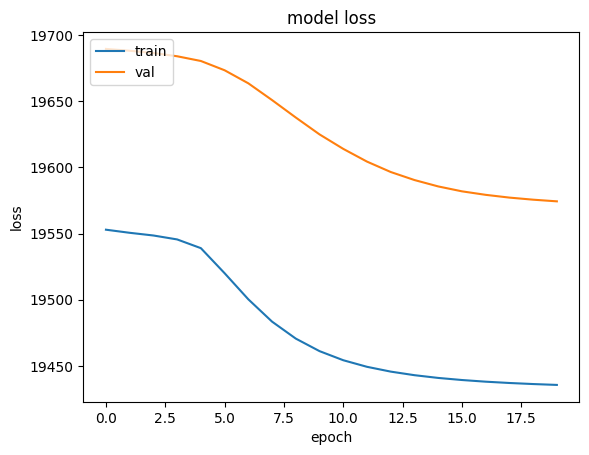

In [13]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

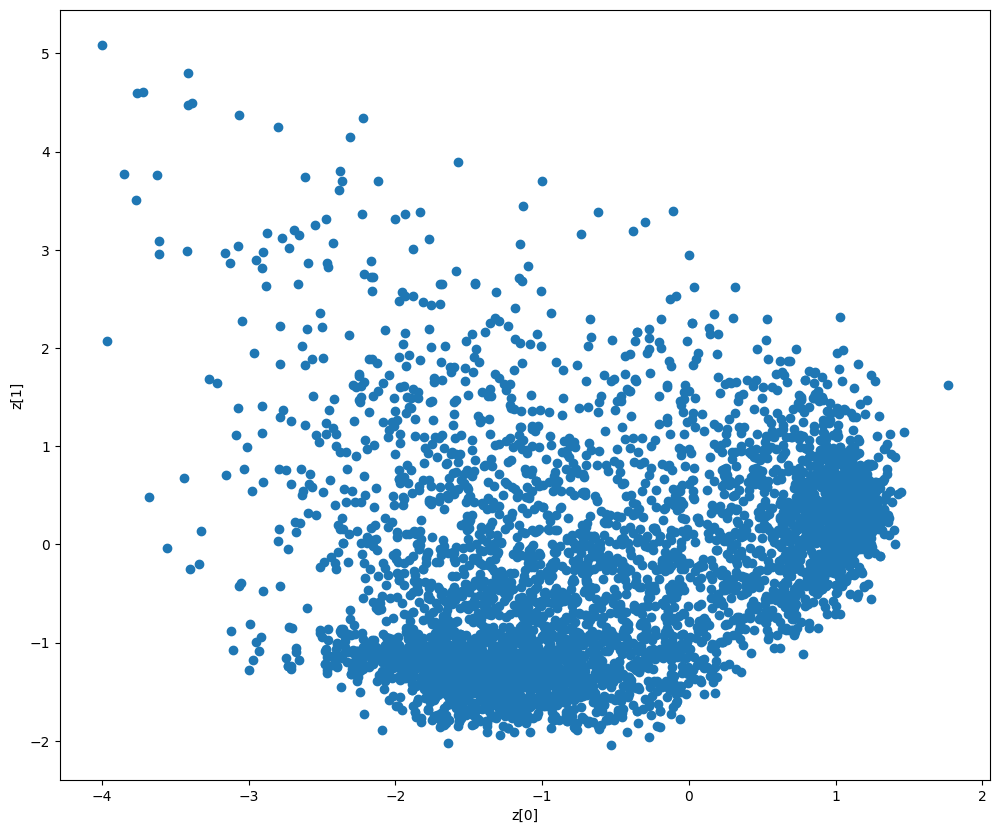

In [14]:
def plot_label_clusters(encoder, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



plot_label_clusters(encoder, r_train_set)
